## Load required packages

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
rcpars = {'figure.dpi': 110,
          'axes.grid': True,
         }
plt.rcParams.update(rcpars)

In [4]:
from hfsolver import solver

In [ ]:
nus = np.arange(-5, 10, .1)
x_t = np.empty(nus.shape)
x_0 = np.empty(nus.shape)

alpha = 0.05
for j, nu in enumerate(nus):
#     print(nu)
    x_t[j], x_0[j] = solver(nu, alpha)

fig, ax = plt.subplots()

fig.suptitle('$\\alpha$ = %g'%alpha)

ax.plot(nus, x_t, label='$x_t$')
ax.plot(nus, x_0, label='$x_0$')

ax.set_xlabel('$\\nu$', fontsize=14)
ax.set_ylabel('x', fontsize=14)
ax.legend()

## Calculate the density distributions in a harmonic potential

In [53]:
from hfsolver.physics import *
from hfsolver.functions import _g32
from hfsolver.physics import _alpha, _nu

N atoms: 0.392977 mln (0.392977)
Global condensed fraction: 0.000
Non-interacting nq: 2.872


"\n# set parameters\nNatom=0.4e6\nomega_ho=2*pi*3.24e3\ndr=1e-7\n\n#initialize array. The TC is the same as noninteracting TC.\nTC_hat=0.9405*hbar*omega_ho*Natom**(1/3)/kB\nT_hat=np.linspace(7e-6,TC_hat*0.999,500)\nmu_hat=np.zeros(len(T_hat))\nf_hat=np.zeros(len(T_hat))\n\n#first calculate mu from Natom and T, then calculate the BEC fraction.\nfor j in range (0,len(T_hat)):\n    mu_hat[j]=brentq(mexhat0,0.01, 10, args=(T_hat[j],omega_ho,dr,Natom))\n    f_hat[j]=mexhat(mu_hat[j], T_hat[j], omega_ho, dr,Natom)\n    \n#plot results\nfig, ax = plt.subplots()\n#ax.plot(T_hat/TC_hat,mu_hat, label='$\\mu$')\nax.plot(T_hat/TC_hat,f_hat, label='BEC fraction')\n#ax.plot(Tlist*1e6,mulist, label='$mu$')\n#ax.plot(Tlist*1e6, BECflist, label='$BECf$')\nax.legend()\nax.set_xlabel('T [uK]')\nax.set_ylabel('mu [uK]')\n"

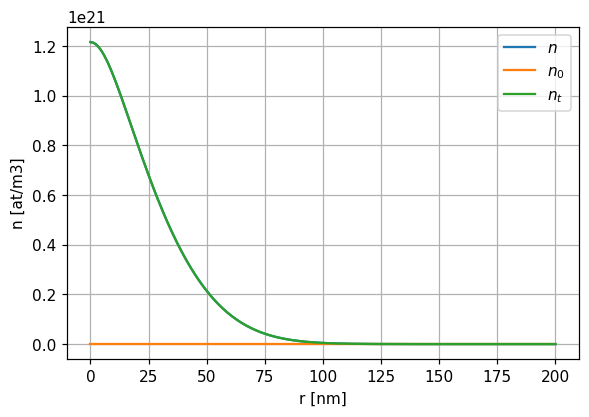

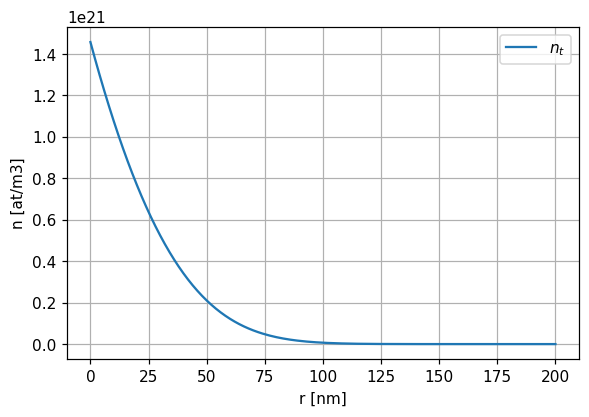

In [251]:
# plot the density profile to get a sense
def plotn(mu,T,omega_ho,dr):
    #mu is in uk
    mu0=mu*1e-6*kB
    Trec=2.39e-6
    # Rmax defines the cutoff
    Rmax= 20e-6
    fun_n, fun_n0, mu_radial, r, alpha = solver_harmonic_trap(mu0, T, omega_ho, dr=dr, Rmax=Rmax)
    n = fun_n(mu_radial)
    n0 = fun_n0(mu_radial)
    cond_frac = n0/n
    
    #atom count
    N = 4*pi * trapz(n*r**2, r)
    cond_frac = n0/n
    N = 4*pi * trapz(n*r**2, r)
    N0 = 4*pi * trapz(n0*r**2, r)
    N2 = integrate_N_harmonic_trap(mu0, omega_ho, n, mu_radial)
    print('N atoms: %g mln (%g)'%(N*1e-6, N2*1e-6))
    print('Global condensed fraction: %.3f'%(N0/N))
    
    np.savetxt('HFn0.csv', n0, fmt = '%.6f')
    np.savetxt('HFnt.csv', n-n0, fmt = '%.6f')
  
    #plot the density profile
    fig, ax = plt.subplots()
    ax.plot(r/dr,n, label='$n$')
    #ax.plot(r/dr,fn(r), label='$fn$')
    ax.plot(r/dr,n0, label='$n_0$')
    ax.plot(r/dr,n - n0, label='$n_t$')
    # ax.set_xlim(xmax=55)
    
    # the unit of the plot depends on dr
    ax.legend()
    ax.set_xlabel('r [nm]')
    ax.set_ylabel('n [at/m3]')
    
    # overlap factor for BEC-thermal scattering
    #epsilon=Trec*np.ones(mu_radial.shape)-mu_radial/kB+2*g_int*n/kB
    epsilon=Trec*np.ones(mu_radial.shape)+g_int*n0/kB
    nq= 1/(np.exp(epsilon/T)-1)
    N0nq = 4*pi * trapz(nq*n0*r**2, r)
    if N0>0:
        print('Averaged nq: %.3f'%(N0nq/N0))
    nq0 = 1/(np.exp(Trec/T)-1)
    print('Non-interacting nq: %.3f'%(nq0))

#calculate BEC fraction for given mu and T    
def mexhat(mu0, T, omega_ho, dr,Natom):
    #mu0 is in uK
    mu0=mu0*kB*1e-6
    Trec=2.39e-6
    Rmax=20e-6
    r = np.arange(0, Rmax, dr)
    aho=np.sqrt(hbar/mass/omega_ho)
    lambdaT=lambda_therm(T)
    r0=np.sqrt(2*mu0/mass/omega_ho**2)
    mu=np.maximum(mu0*(1-r**2/r0**2),np.zeros(len(r)))
    n0=mu/g_int
    
    #calculate nt
    nt= np.zeros(len(r))
    for j in range(0,len(r)):
        mut=mu0-(0.5*mass*omega_ho**2*r[j]**2 + 2*g_int*n0[j])
        nt[j]=mp.fp.polylog(3/2,np.exp(mut/kB/T))/(lambdaT**3)
    
    n=n0+nt
    N0 = 4*pi * trapz(n0*r**2, r)
    N= 4*pi * trapz(n*r**2, r)
    
    #return N0/N-1e-6

    print('N atoms: %g mln'%( N*1e-6))
    print('Global condensed fraction: %.3f'%(N0/N))
    
    # overlap factor for BEC-thermal scattering
    #epsilon=Trec*np.ones(mu_radial.shape)-mu_radial/kB+2*g_int*n/kB
    epsilon=Trec*np.ones(mu.shape)+g_int*n0/kB
    nq= 1/(np.exp(epsilon/T)-1)
    N0nq = 4*pi * trapz(nq*n0*r**2, r)
    if N0>0:
        print('Averaged nq: %.3f'%(N0nq/N0))
    
    np.savetxt('Mexn0.csv', n0, fmt = '%.6f')
    np.savetxt('Mexnt.csv', nt, fmt = '%.6f')
    
    fig, ax = plt.subplots()
    ax.plot(r/dr,n, label='$n$')
    #ax.plot(r/dr,fn(r), label='$fn$')
    ax.plot(r/dr,n0, label='$n_0$')
    ax.plot(r/dr,nt,label='$n_t$')
    #ax.plot(r/dr,n - n0, label='$n_t$')
    # ax.set_xlim(xmax=55)
    
    # the unit of the plot depends on dr
    ax.legend()
    ax.set_xlabel('r [nm]')
    ax.set_ylabel('n [at/m3]')

# solve mu for given atom number in mexican hat approximation    
def mexhat0(mu0, T, omega_ho, dr,Natom):
    mu0=mu0*kB*1e-6
    Trec=2.39e-6
    Rmax=20e-6
    r = np.arange(0, Rmax, dr)
    #TC=0.9405*hbar*omega_ho*N**(1/3)/kB
    #T=TTC*TC
    aho=np.sqrt(hbar/mass/omega_ho)
    #f=1-TTC**3
    #mu0=hbar*omega_ho/2*(15*a_scatt*N*f/aho)**(2/5)
    lambdaT=lambda_therm(T)
    r0=np.sqrt(2*mu0/mass/omega_ho**2)
    mu=np.maximum(mu0*(1-r**2/r0**2),np.zeros(len(r)))
    n0=mu/g_int
    
    
    nt= np.zeros(len(r))
    for j in range(0,len(r)):
        mut=mu0-(0.5*mass*omega_ho**2*r[j]**2 + 2*g_int*n0[j])
        nt[j]=mp.fp.polylog(3/2,np.exp(mut/kB/T))/(lambdaT**3)
    
    n=n0+nt
    N0 = 4*pi * trapz(n0*r**2, r)
    N= 4*pi * trapz(n*r**2, r)
    
    return N-Natom

    print('N atoms: %g mln'%( N*1e-6))
    print('Global condensed fraction: %.3f'%(N0/N))
    
    # overlap factor for BEC-thermal scattering
    #epsilon=Trec*np.ones(mu_radial.shape)-mu_radial/kB+2*g_int*n/kB
    epsilon=Trec*np.ones(mu.shape)+g_int*n0/kB
    nq= 1/(np.exp(epsilon/T)-1)
    N0nq = 4*pi * trapz(nq*n0*r**2, r)
    if N0>0:
        print('Averaged nq: %.3f'%(N0nq/N0))
    
    
    fig, ax = plt.subplots()
    ax.plot(r/dr,n, label='$n$')
    #ax.plot(r/dr,fn(r), label='$fn$')
    ax.plot(r/dr,n0, label='$n_0$')
    ax.plot(r/dr,nt,label='$n_t$')
    #ax.plot(r/dr,n - n0, label='$n_t$')
    # ax.set_xlim(xmax=55)
    
    # the unit of the plot depends on dr
    ax.legend()
    ax.set_xlabel('r [nm]')
    ax.set_ylabel('n [at/m3]')

def thermal(TTC, omega_ho, dr,Natom):
    mu0=0
    Trec=2.39e-6
    Rmax=20e-6
    r = np.arange(0, Rmax, dr)
    TC=0.9405*hbar*omega_ho*Natom**(1/3)/kB
    T=TTC*TC
    lambdaT=lambda_therm(T)
    
    nt= np.zeros(len(r))
    for j in range(0,len(r)):
        mut=mu0-0.5*mass*omega_ho**2*r[j]**2
        nt[j]=mp.fp.polylog(3/2,np.exp(mut/kB/T))/(lambdaT**3)
        
    Nt= 4*pi * trapz(nt*r**2, r)
    np.savetxt('thermal_ideal_BECf30.csv', nt, fmt = '%.6f')
    np.savetxt('r.csv', r*1e6, fmt = '%.6f')
    
    fig, ax = plt.subplots()
    ax.plot(r/dr,nt,label='$n_t$')
    #ax.plot(r/dr,n - n0, label='$n_t$')
    # ax.set_xlim(xmax=55)
    
    # the unit of the plot depends on dr
    ax.legend()
    ax.set_xlabel('r [nm]')
    ax.set_ylabel('n [at/m3]')

    
    

#example mu=2uK, T=11uK
plotn(2.9, 8.0e-6, 2*pi*2.7e3, 1e-7)
#plotn(4.57, 6.4e-6, 2*pi*2.7e3, 1e-9)
#mexhat(3.41,6.65e-6,2*pi*2.7e3,1e-9,0.4e6)
#thermal(0.888,2*pi*2.7e3,1e-9,0.4e6)
thermal(1,2*pi*2.7e3,1e-7,0.4e6)
'''
# set parameters
Natom=0.4e6
omega_ho=2*pi*3.24e3
dr=1e-7

#initialize array. The TC is the same as noninteracting TC.
TC_hat=0.9405*hbar*omega_ho*Natom**(1/3)/kB
T_hat=np.linspace(7e-6,TC_hat*0.999,500)
mu_hat=np.zeros(len(T_hat))
f_hat=np.zeros(len(T_hat))

#first calculate mu from Natom and T, then calculate the BEC fraction.
for j in range (0,len(T_hat)):
    mu_hat[j]=brentq(mexhat0,0.01, 10, args=(T_hat[j],omega_ho,dr,Natom))
    f_hat[j]=mexhat(mu_hat[j], T_hat[j], omega_ho, dr,Natom)
    
#plot results
fig, ax = plt.subplots()
#ax.plot(T_hat/TC_hat,mu_hat, label='$\mu$')
ax.plot(T_hat/TC_hat,f_hat, label='BEC fraction')
#ax.plot(Tlist*1e6,mulist, label='$mu$')
#ax.plot(Tlist*1e6, BECflist, label='$BECf$')
ax.legend()
ax.set_xlabel('T [uK]')
ax.set_ylabel('mu [uK]')
'''

In [207]:
np.savetxt('TTC0.25V.csv', T_hat/TC_hat, fmt = '%.6f')
np.savetxt('BECf0.25V.csv', f_hat, fmt = '%.6f')
np.savetxt('mu0.25V.csv', mu_hat, fmt = '%.6f')

## Calculate chemical potential and BEC fraction for different temperatures

Transition temperature T_C: 8.040 uK


Text(0, 0.5, 'mu [uK]')

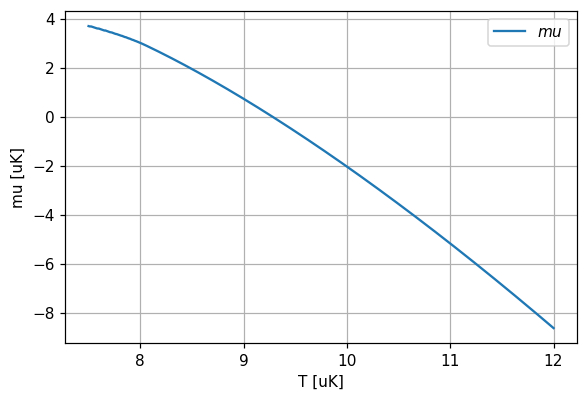

In [7]:
import numpy as np
from scipy.optimize import brentq
 
# initialize parameters
Natom=0.4e6

# this omega is for 0.175V trap!
omega_ho = 2*pi * 2.7e3
dr = 1e-7
# temperature range
Ti=7.5e-6
Tf=12e-6

# solve for chemical potential mu(T)
def calc(mu,T,omega_ho,dr,Natom):
    #mu is in uk
    mu0=mu*1e-6*kB
    Trec=2.39e-6
    #Rmax defines the cutoff, 20um seems to be enough (from the density profile shown above)
    Rmax= 20e-6
    fun_n, fun_n0, mu_radial, r, alpha = solver_harmonic_trap(mu0, T, omega_ho, dr=dr, Rmax=Rmax)
    n = fun_n(mu_radial)
    n0 = fun_n0(mu_radial)
    cond_frac = n0/n
    N = 4*pi * trapz(n*r**2, r)
    return N-Natom

# solve for TC from the BEC fraction
def calcBECf(mu,T,omega_ho,dr,Natom):
    #mu is in uk
    mu0=mu*1e-6*kB
    Trec=2.39e-6
    Rmax= 20e-6
    fun_n, fun_n0, mu_radial, r, alpha = solver_harmonic_trap(mu0, T, omega_ho, dr=dr, Rmax=Rmax)
    n = fun_n(mu_radial)
    n0 = fun_n0(mu_radial)
    N = 4*pi * trapz(n*r**2, r)
    N0 = 4*pi * trapz(n0*r**2, r)
    return N0/N

    
# initialization of temperature range array                    
Tlist=np.linspace (Ti,Tf,500)
mulist= np.empty(Tlist.shape)
BECflist =np.empty(Tlist.shape)

#calculate mu and BEC fraction for each temperature
for j in range(0, len(Tlist)):
    #note the lower and upper range for solving the equation should be changed to make sure there is a solution inside
    mulist[j] = brentq(calc,-20, 10, args=(Tlist[j],omega_ho,dr,Natom))
    BECflist[j] = calcBECf(mulist[j],Tlist[j],omega_ho,dr,Natom)-1e-6 #here the extra 1e-6 is just to shift the plateau and help finding the TC with BECf=0

#interpolating the mu and BEC fraction results
mufit = interp1d(Tlist, mulist, kind='cubic')
BECffit = interp1d(Tlist, BECflist, kind='cubic')

# calculate TC
TC = brentq(BECffit,Ti, Tf)
print('Transition temperature T_C: %.3f uK'%(TC*1e6))

#plot the results
fig, ax = plt.subplots()
ax.plot(Tlist*1e6,mufit(Tlist), label='$mu$')
#ax.plot(Tlist*1e6,mulist, label='$mu$')
#ax.plot(Tlist*1e6, BECflist, label='$BECf$')
ax.legend()
ax.set_xlabel('T [uK]')
ax.set_ylabel('mu [uK]')

## Import the suppression factor C from Mathematica (used in $1- 8\sqrt{2}Ca/\lambda_T$)

Text(0, 0.5, 'Supression C')

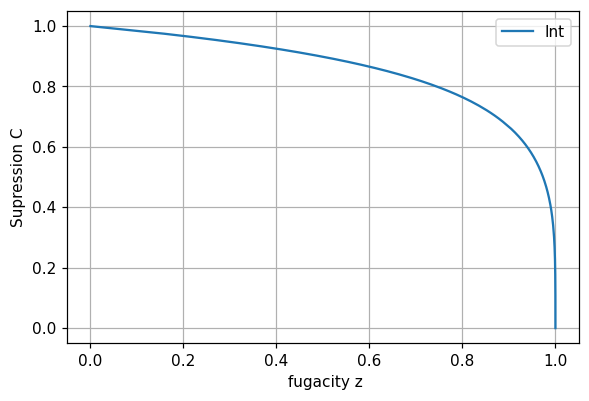

In [8]:
from numpy import genfromtxt

#load C(z) from csv file
C = genfromtxt('C.csv', delimiter=',',encoding="utf8")
z = genfromtxt('z.csv', delimiter=',',encoding="utf8")

#manually correct the first element of the arrays
C[0] = 1
z [0] = 0
Cz = interp1d(z, C, kind='cubic')

#plot the function as a sanity check
fig, ax = plt.subplots()
ax.plot(z,Cz(z), label='Int')
ax.legend()
ax.set_xlabel(' fugacity z')
ax.set_ylabel('Suppression C')

## Calculate the bosonic enhancement factor in light scattering

Text(0, 0.5, 'Enhancement')

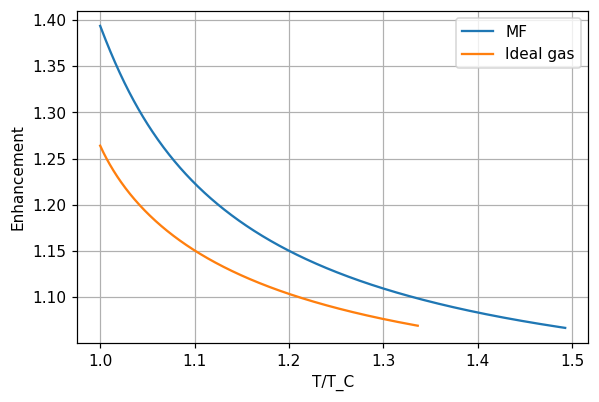

In [12]:
import math
from scipy import integrate
import numpy as np
import mpmath as mp  # fast, low precision implementation
from scipy.optimize import brentq

#mu=3.9
#T=9.75e-6
#TC=9.72e-6
#Natom=0.4e6
#omega_ho = 2*pi * 3.3e3
#dr = 1e-7
kappa=0.514

# calculate chemical potential mu
def calc(mu,T,omega_ho,dr,Natom):
    #mu is in uk
    mu0=mu*1e-6*kB
    Trec=2.39e-6
    Rmax= 20e-6
    fun_n, fun_n0, mu_radial, r, alpha = solver_harmonic_trap(mu0, T, omega_ho, dr=dr, Rmax=Rmax)
    n = fun_n(mu_radial)
    n0 = fun_n0(mu_radial)
    cond_frac = n0/n
    N = 4*pi * trapz(n*r**2, r)
    return N-Natom

# interpolating the density profile
def nr(mu,T,omega_ho,dr):
    mu0=mu*1e-6*kB
    Trec=2.39e-6
    Rmax= 20e-6
    fun_n, fun_n0, mu_radial, r, alpha = solver_harmonic_trap(mu0, T, omega_ho, dr=dr, Rmax=Rmax)
    n = fun_n(mu_radial)
    n0 = fun_n0(mu_radial)
    nth = n-n0
    fn = interp1d(r, nth, kind='cubic')
    return fn
 
# calculating the enhancement factor (note that the input parameters need to be self-consistent), dr is seperately defined here
# MF repulsion and pair correlation effects are both present here
def enhance(mu,T,TC,kappa, omega_ho, N):
    #dr need to be redefined
    dr=1e-7
    fn= nr(mu,T,omega_ho,dr)
    # ODT potential
    def UODT(r):
        return 0.5*mass*omega_ho**2*r**2 + 2*g_int*fn(r)
    mu0=mu*1e-6*kB
    zODT=np.exp(mu0/T/kB)
    #TC=0.9405*hbar*omega_ho*N**(1/3)/kB # is this correct in the presence of interactiong? Probably not...
    TTC=T/TC
    ka = a_scatt/lambda_therm(T)
    #calculate the local chemical fugacity zlocal=exp(mu0-V(r))
    def zlocal(r):
        return zODT * np.exp(-1/(kB*T)*UODT(r))
    
    # integration to get enhancement factor in a spherical symmetric potential. Supression facto should be 1-C
    def intergrandODT(r,y,a):
        return (1- 8*np.sqrt(2)*ka*Cz(zlocal(r)))*r**2 / (zODT**(-1)*np.exp( a + y**2 + 1/(kB*T)*UODT(r)) - 1 )  * 1/( zODT**(-1)*np.exp( a + (y + kappa/np.sqrt(TTC))**2 + 1/(kB*T)*UODT(r) ) - 1)
    intODT1, err = integrate.tplquad(intergrandODT, 0, math.inf, -10,  10, 0, 20e-6)
    #intODT2 = trapz(intODT1, r)
    out = 1 + (2*mass*kB*T)**(3/2)*(2*pi)**2/((2*pi*hbar)**3*N)*intODT1
    return out

# calculating the atom number as sanity check (normalized to 1)
def atom(mu,T,TC,kappa, omega_ho, N):
    dr=1e-7
    fn= nr(mu,T,omega_ho,dr)
    # ODT potential
    def UODT(r):
        return 0.5*mass*omega_ho**2*r**2 + 2*g_int*fn(r)
    mu0=mu*1e-6*kB
    zODT=np.exp(mu0/T/kB)
    #TC=0.9405*hbar*omega_ho*N**(1/3)/kB # is this correct in the presence of interactiong? Probably not...
    TTC=T/TC
    # integration to get enhancement factor in a spherical symmetric potential
    def intergrandODT(r,y,a):
        return r**2 / (zODT**(-1)*np.exp( a + y**2 + 1/(kB*T)*UODT(r)) - 1 ) 
    intODT1, err = integrate.tplquad(intergrandODT, 0, math.inf, -10,  10, 0, 20e-6)
    out = (2*mass*kB*T)**(3/2)*(2*pi)**2/((2*pi*hbar)**3*N)*intODT1
    return out

#calculate fugacity z from T/TC for ideal gas in harmonic trap
def fugBose(TTC):
    def zcal(z, TTC):
        return mp.fp.polylog(3,z)-mp.fp.polylog(3,1)/TTC**3
    z0 = brentq(zcal, 0,1, args=(TTC))
    return z0

# calculating the enhancement factor (note that the input parameters need to be self-consistent), dr is seperately defined here
# Here only the MF repulsion effect is considered, but not the pair correlation
def enhanceMF(mu,T,TC,kappa, omega_ho, N):
    #dr need to be redefined
    dr=1e-7
    fn= nr(mu,T,omega_ho,dr)
    # ODT potential
    def UODT(r):
        return 0.5*mass*omega_ho**2*r**2 + 2*g_int*fn(r)
    mu0=mu*1e-6*kB
    zODT=np.exp(mu0/T/kB)
    #TC=0.9405*hbar*omega_ho*N**(1/3)/kB # is this correct in the presence of interactiong? Probably not...
    TTC=T/TC
    
    # integration to get enhancement factor in a spherical symmetric potential. Supression facto should be 1-C
    def intergrandODT(r,y,a):
        return r**2 / (zODT**(-1)*np.exp( a + y**2 + 1/(kB*T)*UODT(r)) - 1 )  * 1/( zODT**(-1)*np.exp( a + (y + kappa/np.sqrt(TTC))**2 + 1/(kB*T)*UODT(r) ) - 1)
    intODT1, err = integrate.tplquad(intergrandODT, 0, math.inf, -10,  10, 0, 20e-6)
    out = 1 + (2*mass*kB*T)**(3/2)*(2*pi)**2/((2*pi*hbar)**3*N)*intODT1
    return out

# calculating the enhancement factor for ideal gas
def enhance0(T,kappa, omega_ho, N):    
    # ODT potential
    def UODT(r):
        return 0.5*mass*omega_ho**2*r**2
    
    TC=0.9405*hbar*omega_ho*N**(1/3)/kB # is this ccorrect in the presence of interactiong? Probably not...
    TTC=T/TC
    zODT= fugBose(TTC)
    # integration to get enhancement factor in a spherical symmetric potential
    def intergrandODT(r,y,a):
        return r**2 / (zODT**(-1)*np.exp( a + y**2 + 1/(kB*T)*UODT(r)) - 1 )  * 1/( zODT**(-1)*np.exp( a + (y + kappa/np.sqrt(TTC))**2 + 1/(kB*T)*UODT(r) ) - 1)
    intODT1, err = integrate.tplquad(intergrandODT, 0, math.inf, -10,  10, 0, 20e-6)
    out = 1 + (2*mass*kB*T)**(3/2)*(2*pi)**2/((2*pi*hbar)**3*N)*intODT1
    return out

#initialize the array to store enhancement
Tlist1=np.linspace (TC,Tf,500)
#enh = np.empty(Tlist1.shape)
enhMF = np.empty(Tlist1.shape)
#enh0 = np.empty(Tlist1.shape)
#at = np.empty(Tlist1.shape)

#initialize calculations for ideal gas
TC0=0.9405*hbar*omega_ho*Natom**(1/3)/kB
Tlist0=np.linspace (TC0,Tf,500)

#calculate the enhancement for different temperatures
for j in range(0,len(Tlist1)):
    #enh[j] = enhance(mufit(Tlist1[j]),Tlist1[j],TC, kappa,omega_ho,Natom)
    enhMF[j] = enhanceMF(mufit(Tlist1[j]),Tlist1[j],TC, kappa,omega_ho,Natom)
    #at[j] = atom(mufit(Tlist1[j]),Tlist1[j],TC, kappa,omega_ho,Natom)
    #enh0[j] = enhance0(Tlist0[j], kappa, omega_ho, Natom)

fig, ax = plt.subplots()
#ax.plot(Tlist1/TC,enh, label='MF')
ax.plot(Tlist1/TC,enhMF, label='MF')
#ax.plot(Tlist1/TC,at, label='Atom count')
ax.plot(Tlist0/TC0,enh0, label='Ideal gas')
#ax.plot(Tlist*1e6,mulist, label='$mu$')
#ax.plot(Tlist*1e6, BECflist, label='$BECf$')
ax.legend()
ax.set_xlabel('T/T_C')
ax.set_ylabel('Enhancement')

Text(0, 0.5, 'Enhancement')

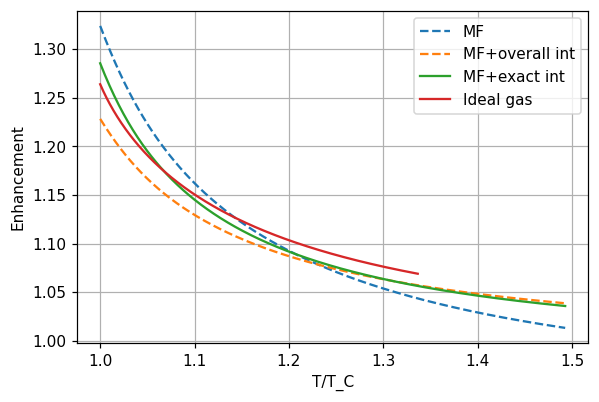

In [17]:
fig, ax = plt.subplots()
ax.plot(Tlist1/TC,enhMF*0.95, label='MF', linestyle='dashed')
ax.plot(Tlist1/TC,(enhMF-1)*0.58+1, label='MF+overall int', linestyle='dashed')
ax.plot(Tlist1/TC,enh, label='MF+exact int')
#ax.plot(Tlist1/TC,at, label='Atom count')
ax.plot(Tlist0/TC0,enh0, label='Ideal gas')
#ax.plot(Tlist*1e6,mulist, label='$mu$')
#ax.plot(Tlist*1e6, BECflist, label='$BECf$')
ax.legend()
ax.set_xlabel('T/T_C')
ax.set_ylabel('Enhancement')

In [13]:
#np.savetxt('TTCint.csv', Tlist1/TC, fmt = '%.6f')
#np.savetxt('EnhanceInt.csv', enh, fmt = '%.6f')
np.savetxt('EnhanceMF.csv', enhMF, fmt = '%.6f')